In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [23]:
#####################################

def load_yelp():
    # Load a csv of floats:
    X = np.genfromtxt("upvote_data.csv", delimiter=",")
    # Load a text file of integers:
    y = np.loadtxt("upvote_labels.txt", dtype=np.int)
    # Load a text file of strings:
    featureNames = open("upvote_features.txt").read().splitlines()
    
    # demean!
    X = pylab.demean(X,axis=0)
    y = pylab.demean(y)
    return X,y,featureNames

def split(data,labels):
    n_train = 4000
    n_valid = 1000
    n_test = 1000
    
    train_d = data[0:n_train,:]
    train_l = labels[0:n_train]
    
    valid_d = data[n_train:n_train+n_valid,:]
    valid_l = labels[n_train:n_train+n_valid]
    
    test_d = data[n_valid::,:]
    test_l = labels[n_valid::]
    
    return train_d,valid_d,test_d,train_l,valid_l,test_l

### lasso!

def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y))) for k_ind in k_range])
    return lambda_max

def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + np.dot(x[:,k],w[k])
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = np.array(w)
        
        # use maximum of weight difference 
        #stop_cond = np.max(weight_diff)
        
        # use mean weight difference 
        
        stop_cond = np.abs(np.mean(weight_diff))
        print('value of lasso run {}'.format(stop_cond))
        #stop_cond_vec.append(stop_cond)
    
    return w

def lasso_loop(x_t,y_t,x_v,y_v):
    w_vec = []
    num_non_zero_vec = []
    lambda_val = lambda_max_func(x_t,y_t)
    lambda_vec = []
    valid_error_vec=[]
    train_error_vec = []
    valid_error_diff = 100
    valid_error_old = 100
    #valid_error_delta = 1e-2
    valid_error_delta = 1e-3

    lambda_ratio = 3/5

    w_init = np.random.random(np.shape(x_t)[1])
    
    while (valid_error_diff>valid_error_delta):
        print('the value of lambda is {}'.format(lambda_val))
        w = lasso_CD(x_t,y_t,lambda_val,w_init)
        
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        w_vec.append(w)

        w_init = np.array(w)
        
        train_error = error_calc(x_t,y_t,w)
        valid_error = error_calc(x_v,y_v,w)
        
        num_non_zero_vec.append(num_non_zero)
        lambda_vec.append(lambda_val)
        lambda_val = lambda_val*lambda_ratio

        train_error_vec.append(train_error)
        valid_error_vec.append(valid_error)
        valid_error_diff = np.abs(valid_error - valid_error_old)
        valid_error_old = copy.copy(valid_error)

        print('The validation error was {}'.format(valid_error))
        print('The validation error difference was {}'.format(valid_error_diff))
    
    return w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec

def error_calc(x,y,w):
    n = np.shape(y)[0]
    error = (1/n)*np.sum((y-np.dot(x,w))**2)
    return error

def plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec):
   
    ax1= plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,train_error_vec,label='training error')
    plt.plot(lambda_vec,valid_error_vec,label='validation error')
    plt.xlabel(r'$ \lambda $')
    plt.title('Training and Validation error for' +'\n' +'various values of Lambda ')
    plt.ylabel('error')
    plt.legend()
    plt.savefig('hw2_valid_train_error_kaggle_noYmean.png')

    ax2 = plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,num_non_zero_vec)
    plt.xlabel(r'$ \lambda $')
    plt.ylabel('Number of non zero entries')
    plt.title('Number of non zero entries for ' + '\n' + 'various values of lambda')
    plt.savefig('hw2_nonzero_kaggle_noYmean.png')
    
def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

### part a

In [17]:
# load data
X,y,featureNames = load_yelp()

# split data
train_d,valid_d,test_d,train_l,valid_l,test_l = split(X,y)


In [18]:
w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d,train_l,valid_d,valid_l)



the value of lambda is 145.92594572640883
value of lasso run 0.1134158004152671
value of lasso run 0.11423912447963078
value of lasso run 0.0008232769259284491
The validation error was 5.272045725276312
The validation error difference was 94.72795427472369
the value of lambda is 87.55556743584529
value of lasso run 0.04969399689968361
value of lasso run 0.0032599307666835095
value of lasso run 0.0020406177329682475
value of lasso run 1.3067509494561146e-05
The validation error was 3.6027388689608317
The validation error difference was 1.6693068563154805
the value of lambda is 52.53334046150717
value of lasso run 0.07465386156557322
value of lasso run 0.0016319973029840188
value of lasso run 0.0010625802252151565
value of lasso run 0.000520777408972338
The validation error was 2.987178707815526
The validation error difference was 0.6155601611453059
the value of lambda is 31.520004276904302
value of lasso run 0.09388550899593723
value of lasso run 0.0013292933964578922
value of lasso run

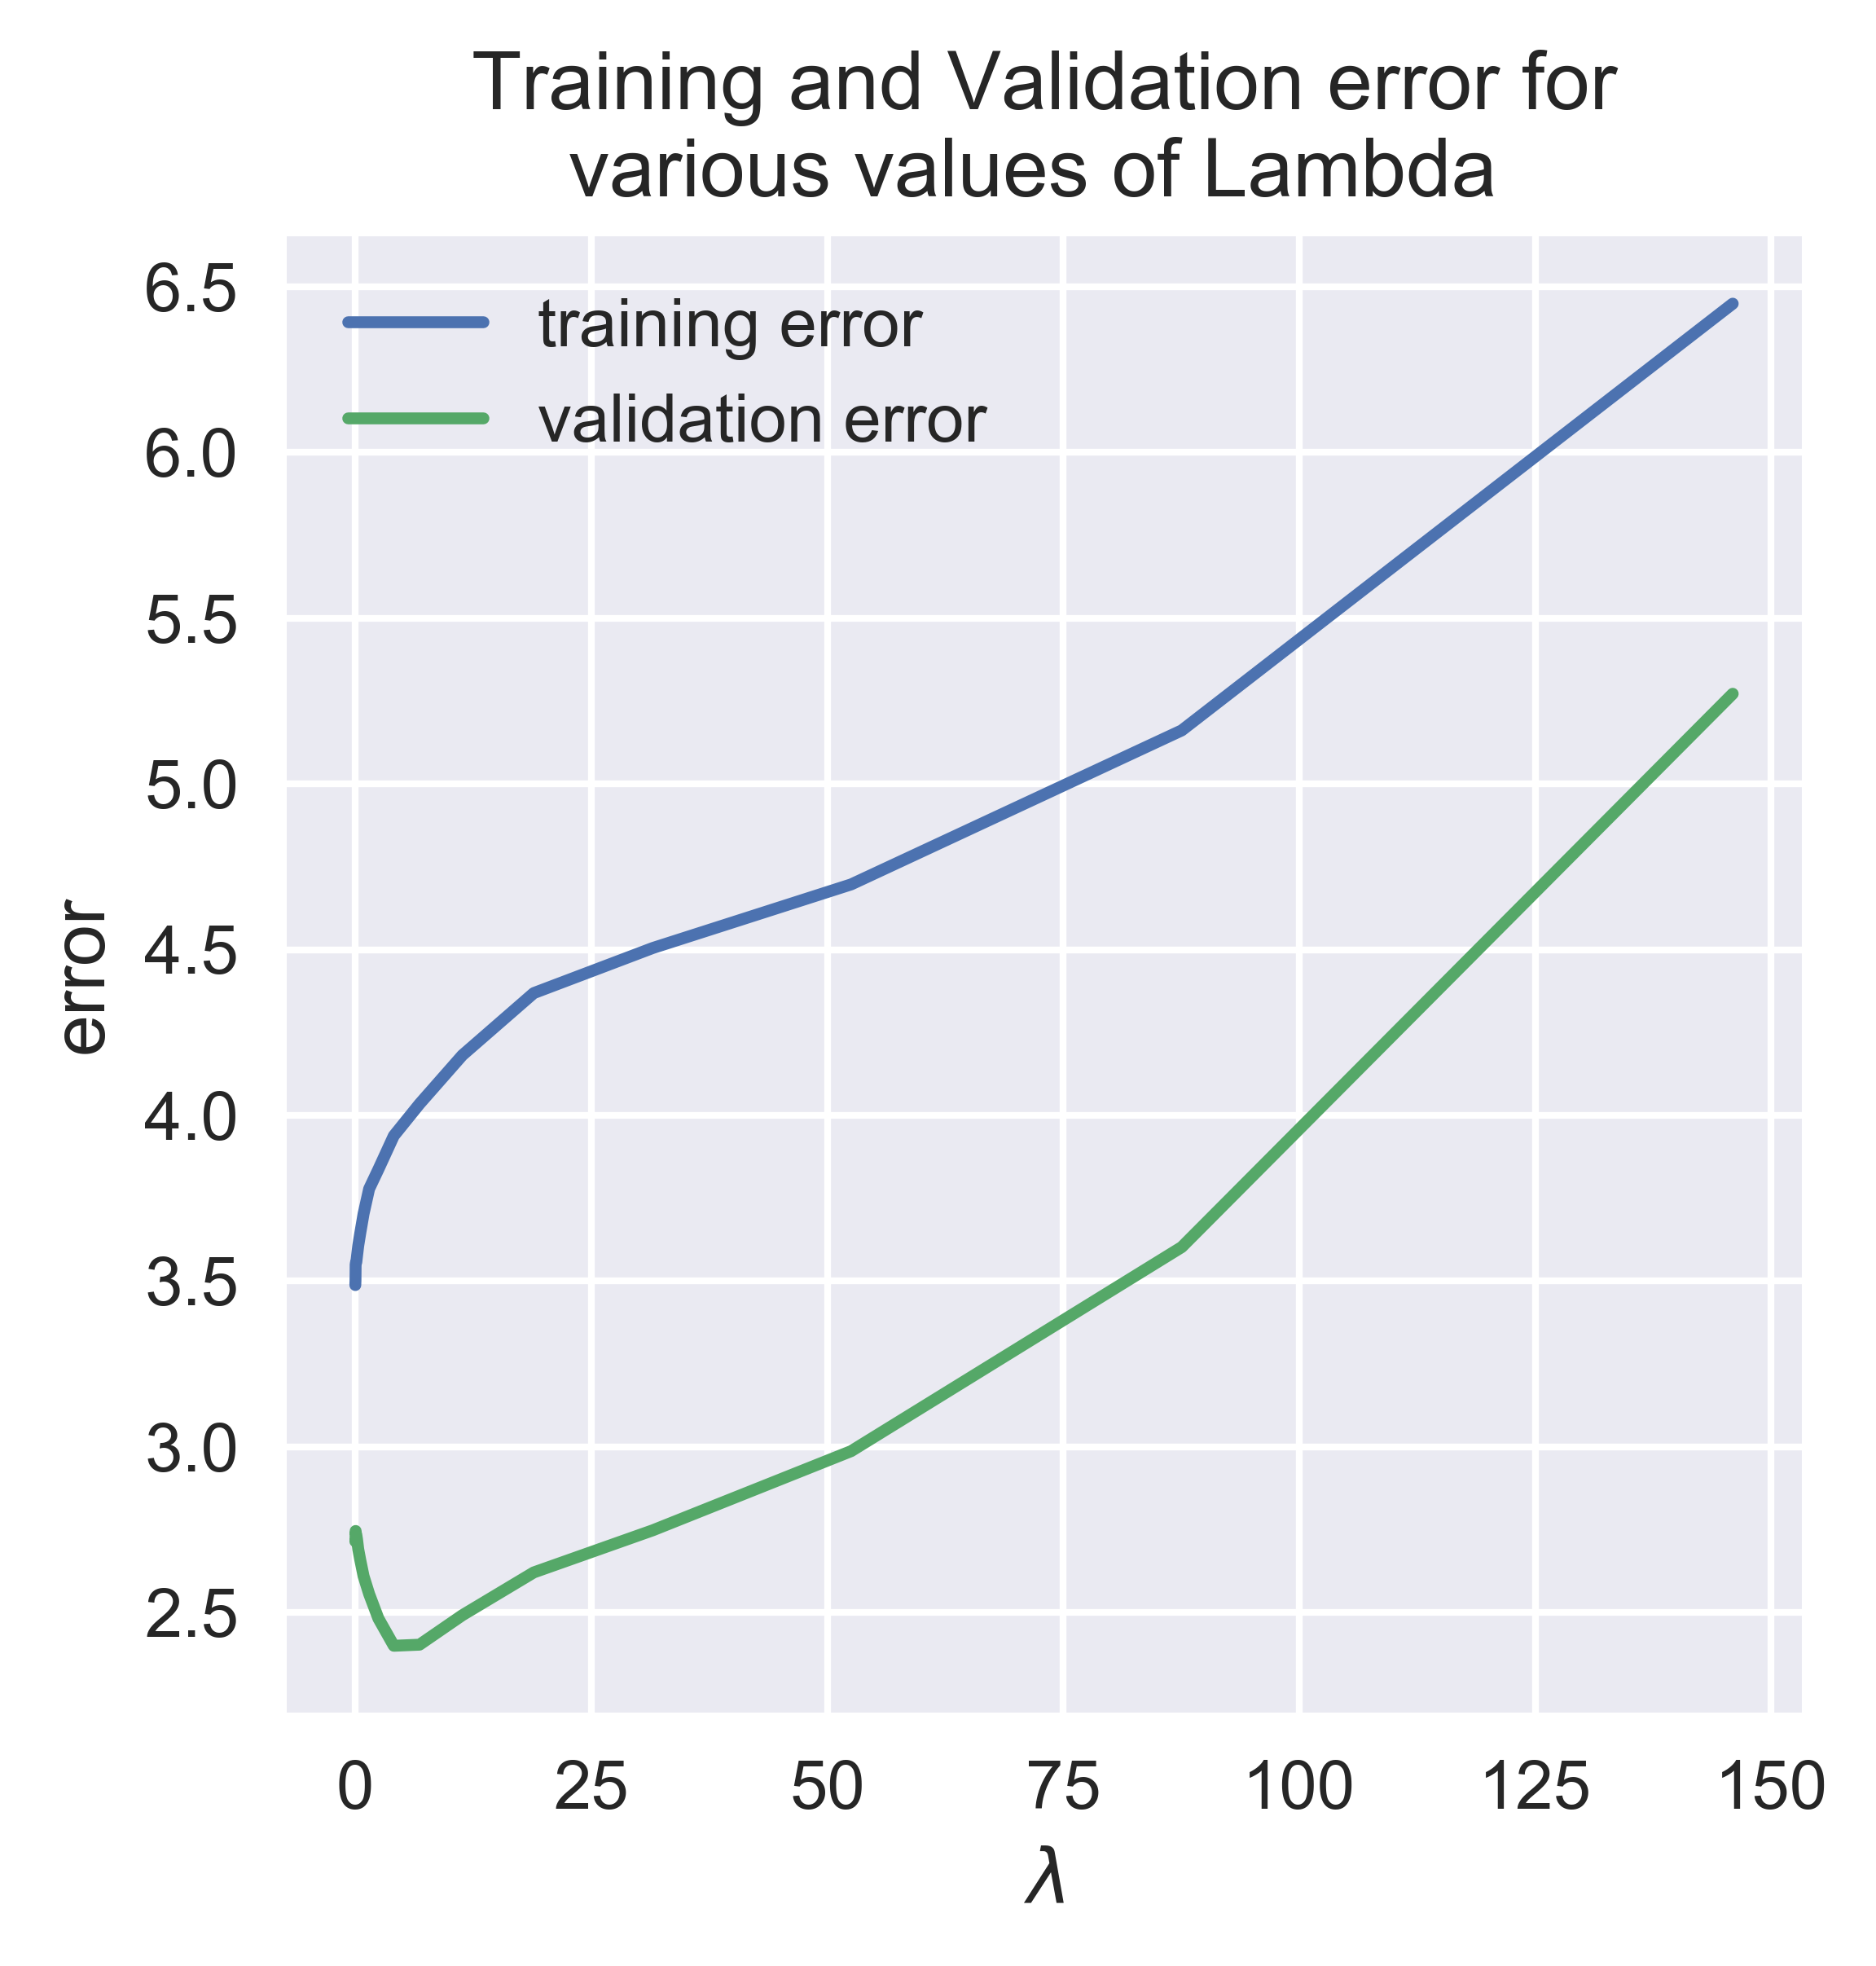

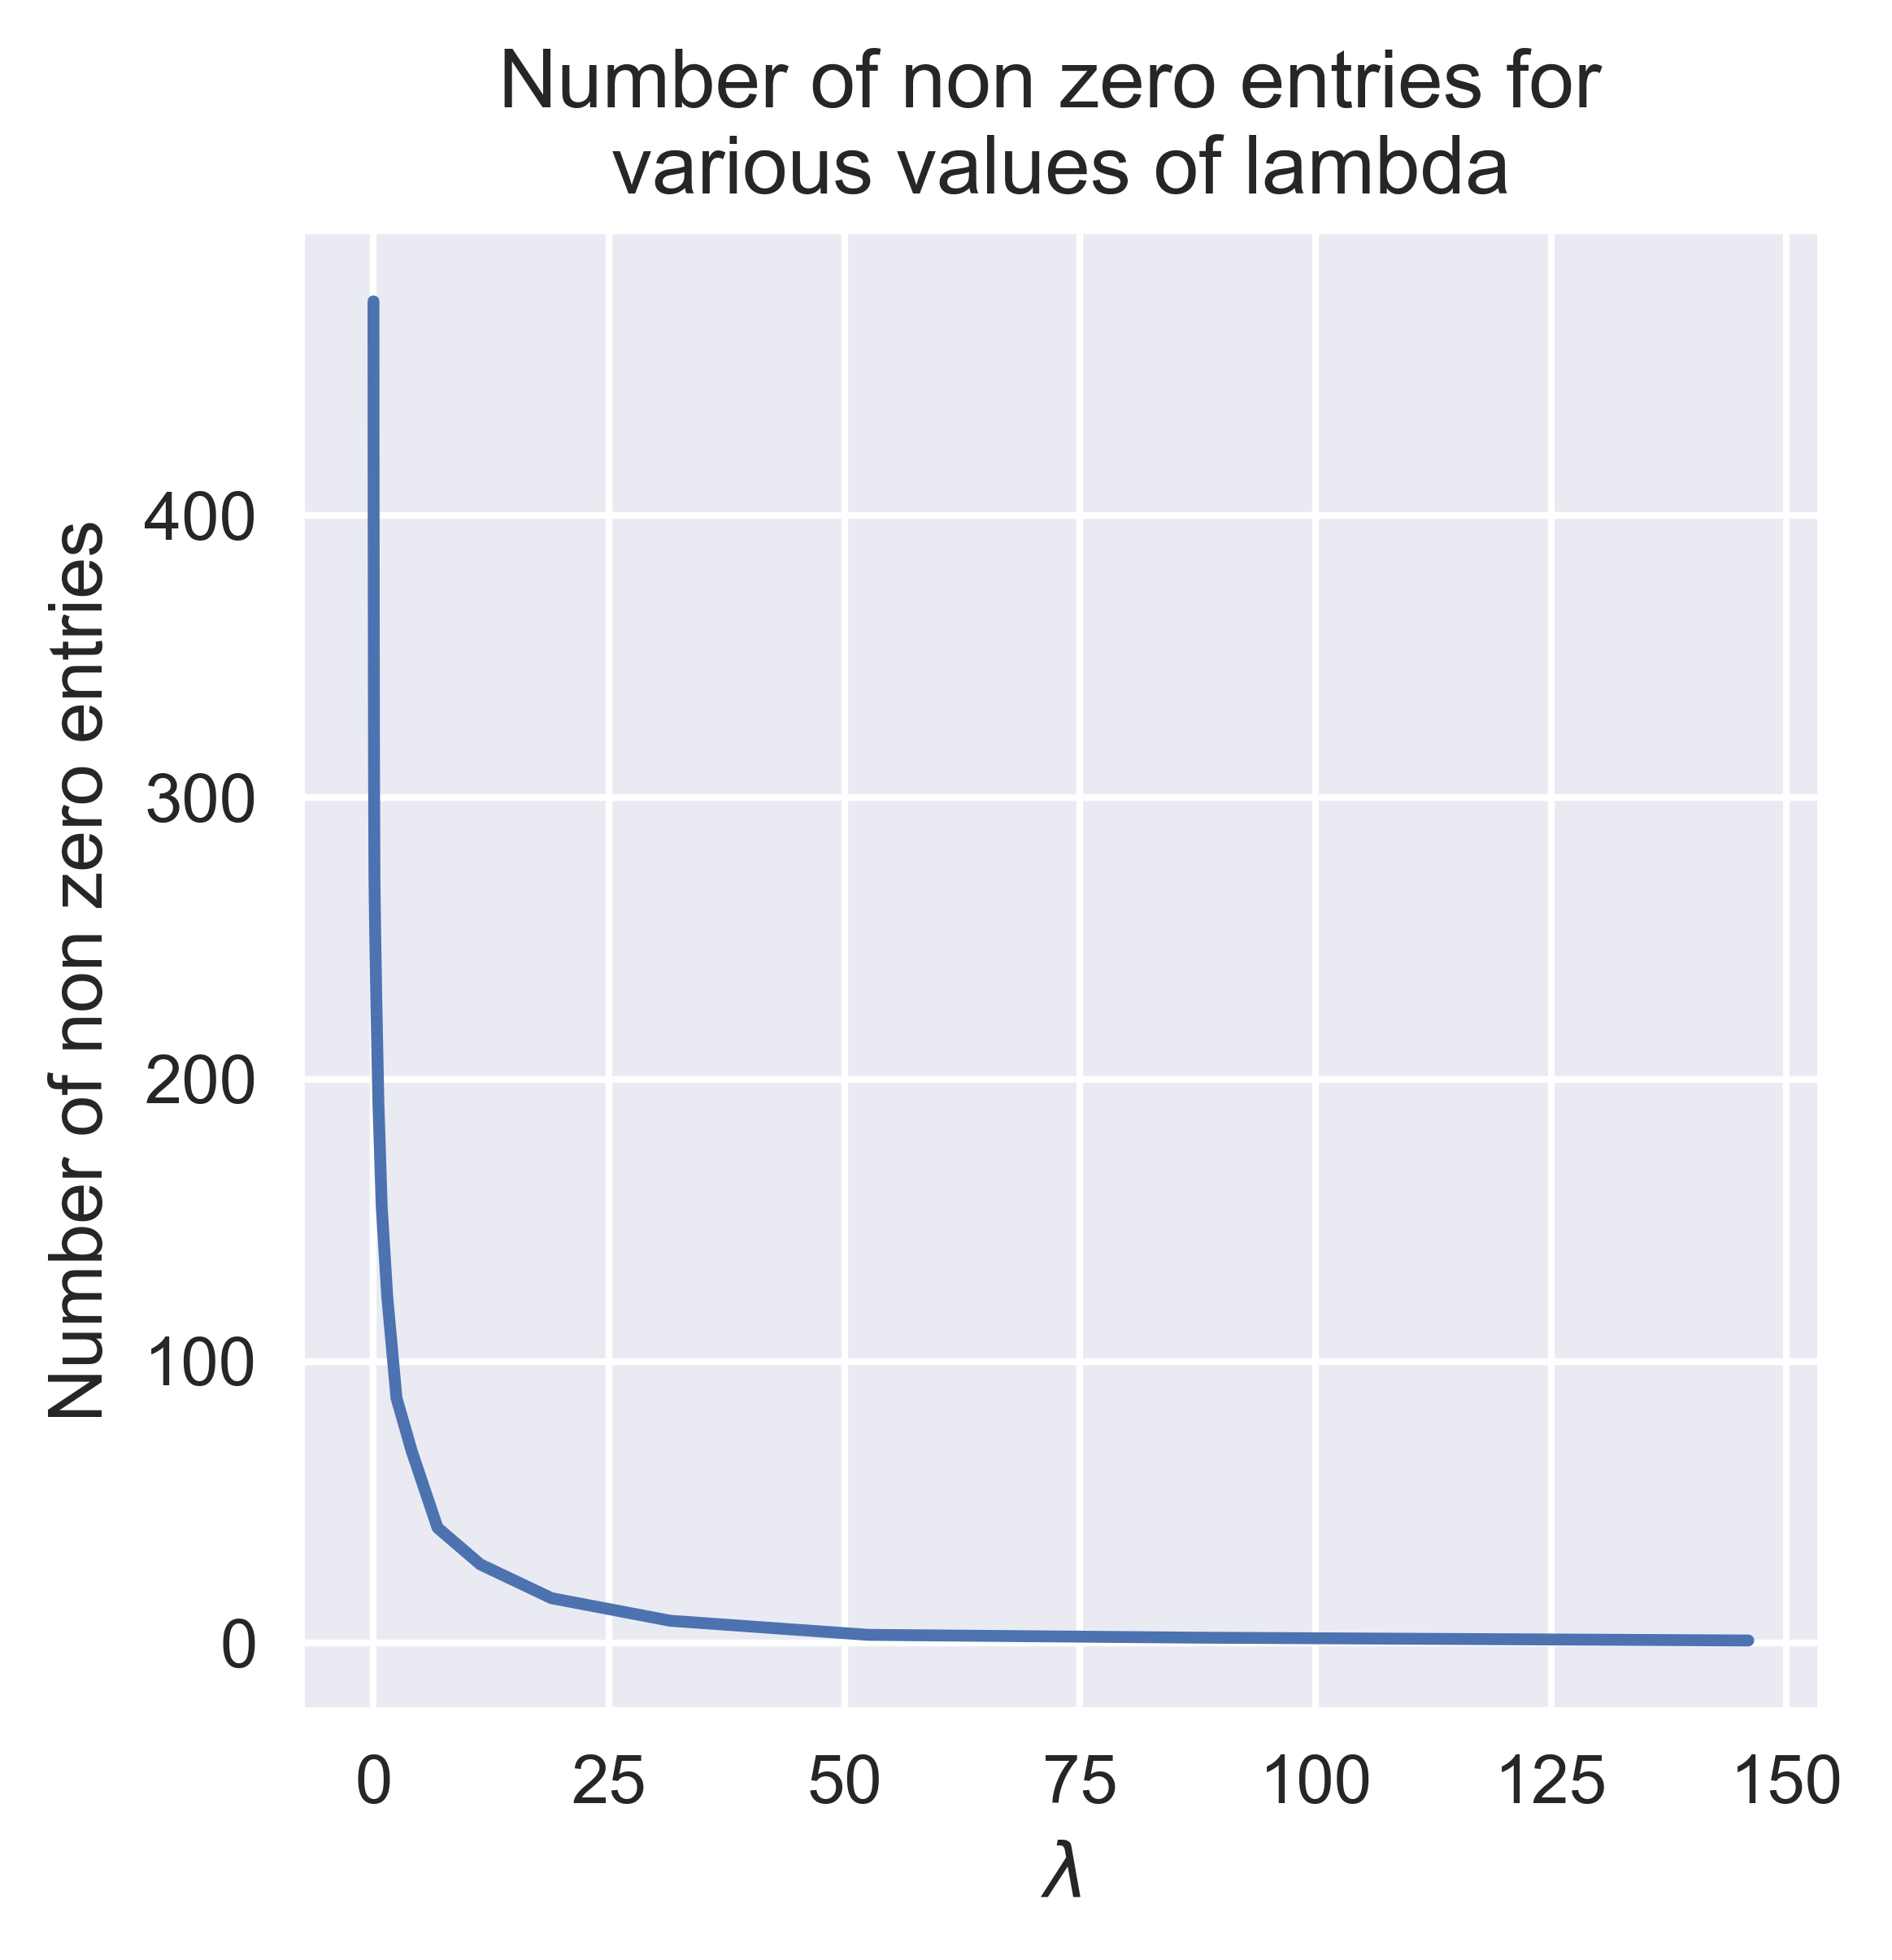

In [24]:
plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec)

### part b

In [20]:
# lambda optimal
ind_valid_min = np.array(np.argmin(valid_error_vec))
lambda_opt = lambda_vec[ind_valid_min]
w_vec_array = np.array(w_vec)
w_best = w_vec_array[ind_valid_min,:]

test_error = error_calc(test_d,test_l,w_best)
print('The test error is {}'.format(test_error))

ind_valid_min
np.shape(ind_valid_min)
np.shape(w_vec)
type(ind_valid_min)
type(w_vec)

The test error is 4.184294354828996


array(7, dtype=int64)

()

(20, 1000)

numpy.ndarray

list

### part c

In [21]:
featureNamesArray = np.array(featureNames)

In [22]:
inds_top10 = np.argpartition(w_best, -10)[-10:]

top10_weight = w_best[inds_top10]
top10_feat = featureNamesArray[inds_top10]
zipped_top10 = list(zip(top10_feat,top10_weight))

print('The top ten features and their weights are {}'.format(zipped_top10))

The top ten features and their weights are [('log(ReviewNumCharacters*UserUsefulVotes)', 9.1088070697217223), ('BusinessNumReviews*InGlendale', 9.6975438464020804), ('ReviewNumCharacters*ReviewNumLineBreaks', 10.284301567972388), ('ReviewInFall*InGlendale', 12.116399826673852), ('sqrt(UserCoolVotes*BusinessNumStars)', 10.56182279407509), ('sq(UserFunnyVotes*BusinessNumStars)', 13.831559848600159), ('sqrt(ReviewNumCharacters*UserFunnyVotes)', 48.035374822177999), ('sqrt(UserFunnyVotes*InPhoenix)', 14.982653428680013), ('UserUsefulVotes*InScottsdale', 15.847208926817922), ('sqrt(ReviewNumCharacters*UserCoolVotes)', 20.231186325442437)]


### scratch section

In [15]:
lambda_opt

4.0849925542867975